## Dash Board

Fill in all its functions as we go

1. Speaker Diarization

## Speaker Diarization - Who Said What

---

### What is Speaker Diarization?

**Diarization** = answering the question **"who spoke when?"**

It's like adding subtitles that say:
- `[00:00 - 00:15] SPEAKER_00: ...`
- `[00:15 - 00:32] SPEAKER_01: ...`

---

### Why Do We Need This?

For bias detection, we need to know:
- **Who is speaking** at any given moment
- **When they started** and stopped talking
- **How many speakers** are in the conversation
- **Which segments belong to which person**

Without diarization, we'd just have raw text with no idea who said what!

---

### How Does It Work?

**Step 1: Audio Analysis**
- The model analyzes voice characteristics (pitch, tone, frequency)
- Identifies unique "voice prints" for each person

**Step 2: Clustering**
- Groups similar voice segments together
- Assigns each group a speaker label (SPEAKER_00, SPEAKER_01, etc.)

**Step 3: Timestamps**
- Marks exactly when each speaker starts and stops talking

---

### Technology We're Using

**pyannote.audio 3.1** 
- State-of-the-art speaker diarization
- Developed by French research team (CNRS)
- Pre-trained on thousands of hours of speech
- Hosted on Hugging Face (requires free API token)

---

### What We'll Get

After diarization, we'll have a **DataFrame** with:

| start | end   | speaker     | duration |
|-------|-------|-------------|----------|
| 0.0   | 5.2   | SPEAKER_00  | 5.2      |
| 5.2   | 12.8  | SPEAKER_01  | 7.6      |
| 12.8  | 18.3  | SPEAKER_00  | 5.5      |

Each row = one speaking turn!

---


In [15]:
# Install all required packages
# Run this cell once

!pip install whisperx pyannote.audio librosa speechbrain torchaudio pandas matplotlib seaborn python-dotenv soundfile


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
# Import all required libraries

# Core speech & audio libraries
import whisperx                          # Speech-to-text with speaker alignment
from pyannote.audio import Pipeline      # Speaker diarization (who spoke when)
import librosa                           # Audio loading & analysis
import librosa.display                   # Audio visualization (waveforms, spectrograms)
from speechbrain.pretrained import EncoderClassifier  # Emotion or speaker classification

# Deep learning & data handling
import torch                             # GPU acceleration (used by WhisperX / PyAnnote)
import pandas as pd                      # Dataframes for diarization/emotion results
import numpy as np                       # Numerical operations & signal processing

# Visualization
import matplotlib.pyplot as plt           # Plotting (timelines, charts, etc.)
import seaborn as sns                     # Prettier, themed plots

# Utilities & file handling
import os                                # File paths & environment management
import re                                # Regex for text cleaning or parsing
import tempfile                          # Temporary files for audio chunks
import soundfile as sf                   # Read/write WAV or FLAC audio files
from dotenv import load_dotenv           # Load API tokens / config from .env
from datetime import datetime            # For timestamps & logging


# Set plotting style
sns.set_style("whitegrid")                # Clean white background with grid
plt.rcParams['figure.dpi'] = 100          # Higher resolution plots

# Load environment variables
load_dotenv()                             # Load from .env file if present
HF_TOKEN = os.getenv("HF_TOKEN")          # Hugging Face API token for PyAnnote

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"

print("=" * 70)
print("SPEAKSENSE - MEDIA BIAS DETECTION DASHBOARD")
print("=" * 70)
print(f"\nAll libraries imported")
print(f"Device: {device.upper()}")                                     # Log device being used
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")    # Log current time                                             
print("\n" + "=" * 70)

SPEAKSENSE - MEDIA BIAS DETECTION DASHBOARD

All libraries imported
Device: CPU
Timestamp: 2025-11-17 22:29:36



Loading: ../data/US_DebateAudio.wav

Audio loaded successfully
  Sample rate: 44100 Hz
  Duration: 565.78s (9.43 min)
  Shape: (24950784,)


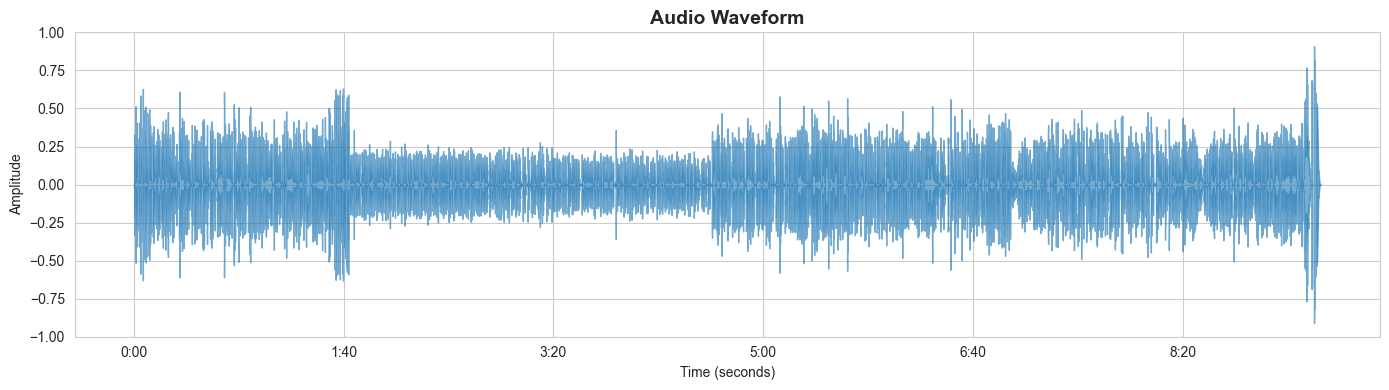

In [17]:
# Audio file path
audio_file = "../data/US_DebateAudio.wav"

print(f"Loading: {audio_file}")

# Load audio with librosa
audio, sample_rate = librosa.load(audio_file, sr=None)
duration = len(audio) / sample_rate                     # Calculate total duration in seconds


print(f"\nAudio loaded successfully")
print(f"  Sample rate: {sample_rate} Hz")
print(f"  Duration: {duration:.2f}s ({duration/60:.2f} min)")
print(f"  Shape: {audio.shape}")

# Quick visualization - Plot waveform

plt.figure(figsize=(14, 4))
librosa.display.waveshow(audio, sr=sample_rate, alpha=0.6, color='#1f77b4')
plt.title('Audio Waveform', fontsize=14, fontweight='bold')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

In [18]:
print("=" * 70)
print("SPEAKER DIARIZATION")
print("=" * 70)

# Load the pre-trained diarization model from Hugging Face
print("\n[1/2] Loading diarization model...")
diarize_model = Pipeline.from_pretrained(
    "pyannote/speaker-diarization-3.1",
    use_auth_token=HF_TOKEN
)

# Run the diarization pipeline on the audio file
print("[2/2] Running speaker diarization...")
diarize_segments = diarize_model(audio_file)

# Convert to DataFrame
diarize_list = []
for turn, _, speaker in diarize_segments.itertracks(yield_label=True):
    diarize_list.append({
        'start': turn.start,
        'end': turn.end,
        'speaker': speaker,
        'duration': turn.end - turn.start
    })
diarize_df = pd.DataFrame(diarize_list)

# Summary statistics
num_speakers = len(diarize_df['speaker'].unique())
print(f"\nDiarization complete!")
print(f"  Speakers identified: {num_speakers}")
print(f"  Total segments: {len(diarize_df)}")
print(f"\nFirst few segments:")
print(diarize_df.head(10))

SPEAKER DIARIZATION

[1/2] Loading diarization model...


c:\Users\norak\SpeakSense\venv\Lib\site-packages\pyannote\audio\core\io.py:212: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  torchaudio.list_audio_backends()


[2/2] Running speaker diarization...


c:\Users\norak\SpeakSense\venv\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
c:\Users\norak\SpeakSense\venv\Lib\site-packages\pyannote\audio\models\blocks\pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  std = sequences.std(dim=-1, correction=1)
c:\Users\norak\SpeakSense\venv\Lib\site-packages\pyannote\audio\c

KeyboardInterrupt: 

In [ ]:
print("=" * 70)
print("TRANSCRIPTION & ALIGNMENT")
print("=" * 70)

# Load WhisperX model (for speech-to-text)
# "base" is a small, efficient model
print("\n[1/3] Loading WhisperX model...")
model = whisperx.load_model("base", device=device, compute_type="int8" if device=="cpu" else "float16")

# Transcribe the full audio into text segments
print("[2/3] Transcribing audio...")
result = model.transcribe(audio_file)

# Align transcription with word-level timestamps for accuracy
# Adds start/end times to each word in the transcript
print("[3/3] Aligning to word-level timestamps...")
model_a, metadata = whisperx.load_align_model(language_code="en", device=device)
result = whisperx.align(result["segments"], model_a, metadata, audio_file, device=device)

print("\nTranscription complete!")
print(f"  Segments: {len(result['segments'])}")
print(f"\nFirst segment preview:")
print(f"  {result['segments'][0].get('text', '')[:100]}...")

TRANSCRIPTION & ALIGNMENT

[1/3] Loading WhisperX model...


c:\Users\norak\SpeakSense\venv\Lib\site-packages\ctranslate2\__init__.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


2025-11-12 20:37:35 - whisperx.asr - INFO - No language specified, language will be detected for each audio file (increases inference time)
2025-11-12 20:37:35 - whisperx.vads.pyannote - INFO - Performing voice activity detection using Pyannote...


Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.5.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint c:\Users\norak\SpeakSense\venv\Lib\site-packages\whisperx\assets\pytorch_model.bin`
c:\Users\norak\SpeakSense\venv\Lib\site-packages\pyannote\audio\core\io.py:212: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  torchaudio.list_audio_backends()


Model was trained with pyannote.audio 0.0.1, yours is 3.4.0. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.8.0+cpu. Bad things might happen unless you revert torch to 1.x.
[2/3] Transcribing audio...
2025-11-12 20:38:03 - whisperx.asr - INFO - Detected language: en (0.99) in first 30s of audio
[3/3] Aligning to word-level timestamps...

Transcription complete!
  Segments: 112

First segment preview:
   She doesn't have a plan....


In [ ]:
print("\n" + "=" * 70)
print("ASSIGNING SPEAKERS TO TRANSCRIPT")
print("=" * 70)

# Combine diarization output with transcription
# Each word/segment now includes a speaker label (who said what)
result = whisperx.assign_word_speakers(diarize_df, result)

print("\nSpeakers assigned to transcript!")
print(f"  Total segments with speakers: {sum(1 for s in result['segments'] if 'speaker' in s)}")


ASSIGNING SPEAKERS TO TRANSCRIPT

Speakers assigned to transcript!
  Total segments with speakers: 112


SPEAKER TIME SHARE ANALYSIS

Speaking Time Breakdown:
  SPEAKER_00: 4.07 min (44.86%)
  SPEAKER_01: 0.12 min (1.32%)
  SPEAKER_02: 4.88 min (53.81%)


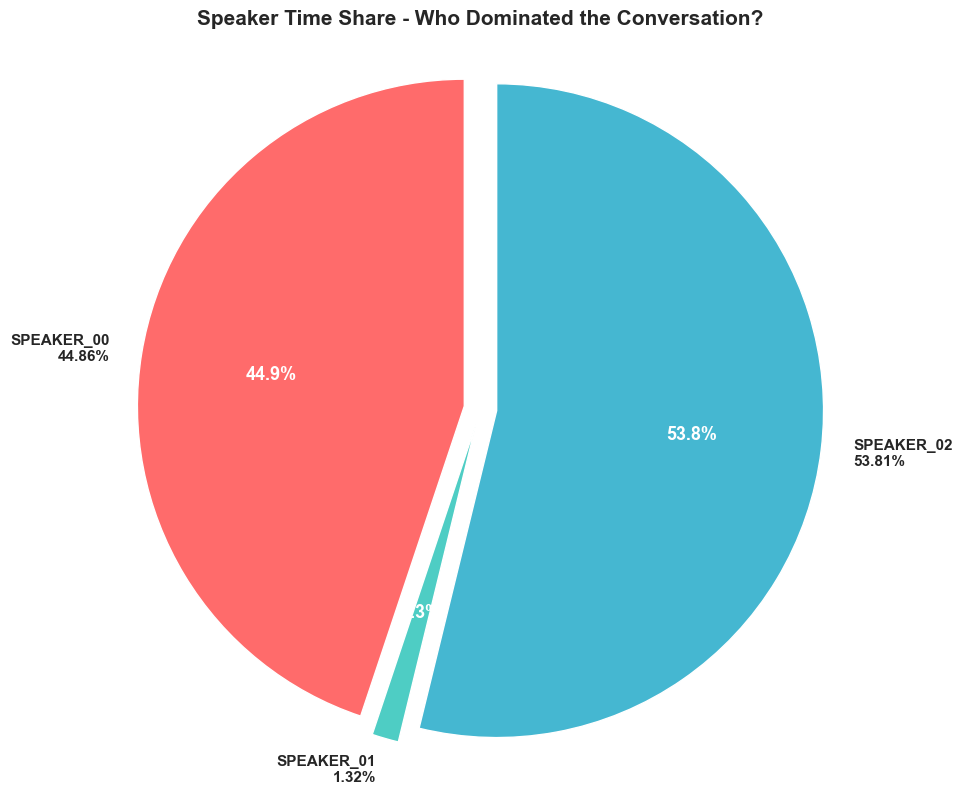

In [ ]:
print("=" * 70)
print("SPEAKER TIME SHARE ANALYSIS")
print("=" * 70)

# Calculate total speaking time per speaker
speaker_time = diarize_df.groupby('speaker')['duration'].sum()
total_time = speaker_time.sum()
speaker_percentages = (speaker_time / total_time * 100).round(2)

# Print statistics
print("\nSpeaking Time Breakdown:")
for speaker, time in speaker_time.items():
    percentage = speaker_percentages[speaker]
    minutes = time / 60
    print(f"  {speaker}: {minutes:.2f} min ({percentage}%)")

# Create pie chart
plt.figure(figsize=(10, 8))
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#ffd93d', '#95e1d3']
explode = [0.05] * len(speaker_time)

wedges, texts, autotexts = plt.pie(
    speaker_time, 
    labels=[f"{s}\n{speaker_percentages[s]}%" for s in speaker_time.index],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors[:len(speaker_time)],
    explode=explode,
    textprops={'fontsize': 11, 'fontweight': 'bold'}
)

# Make percentage text white and bold for readability
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(13)

plt.title('Speaker Time Share - Who Dominated the Conversation?', 
          fontsize=15, fontweight='bold', pad=20)
plt.axis('equal') # Keep pie chart circular
plt.tight_layout()
plt.show()

## Full Transcript with Speaker Labels

Now let's display the complete transcript in a readable format with:
- Speaker labels for each segment
- Timestamps showing when they spoke
- Clean formatting for easy reading

This is useful for:
- **Manual review** - Read what was actually said
- **Quote extraction** - Find important statements
- **Context analysis** - Understand the conversation flow
- **Report generation** - Export for your thesis

In [ ]:
# ============================================================
# FORMATTED TRANSCRIPT WITH SPEAKER LABELS
# ============================================================

print("=" * 70)
print("FULL TRANSCRIPT - US DEBATE")
print("=" * 70)
print("\n")

# ------------------------------------------------------------
# Display each segment with speaker and timestamp
# ------------------------------------------------------------

for idx, segment in enumerate(result['segments'], 1):
    # Extract segment information
    speaker = segment.get('speaker', 'UNKNOWN')
    start = segment['start']
    end = segment['end']
    text = segment.get('text', '').strip()
    
    # Format timestamp as MM:SS
    start_min = int(start // 60)
    start_sec = int(start % 60)
    end_min = int(end // 60)
    end_sec = int(end % 60)
    
    # Print formatted segment
    print(f"[{idx:03d}] {speaker} | [{start_min:02d}:{start_sec:02d} → {end_min:02d}:{end_sec:02d}]")
    print(f"      {text}")
    print()  # Blank line between segments

print("=" * 70)
print(f"✓ Transcript complete: {len(result['segments'])} total segments")
print("=" * 70)

FULL TRANSCRIPT - US DEBATE


[001] SPEAKER_00 | [00:00 → 00:01]
      She doesn't have a plan.

[002] SPEAKER_00 | [00:02 → 00:12]
      She copied Biden's plan and it's like four sentences, like run spot run, four sentences that are just, oh, we'll try and lower taxes.

[003] SPEAKER_00 | [00:12 → 00:13]
      She doesn't have a plan.

[004] SPEAKER_00 | [00:13 → 00:14]
      Take a look at her plan.

[005] SPEAKER_00 | [00:14 → 00:16]
      She doesn't have a plan.

[006] SPEAKER_02 | [00:16 → 00:20]
      I believe in the ambition, the aspirations, the dreams of the American people.

[007] SPEAKER_02 | [00:21 → 00:26]
      And that is why I imagine and have actually a plan to build what I call an opportunity economy.

[008] SPEAKER_02 | [00:27 → 00:28]
      Because here's the thing.

[009] SPEAKER_02 | [00:28 → 00:32]
      We know that we have a shortage of homes in housing.

[010] SPEAKER_02 | [00:32 → 00:35]
      And the cost of housing is too expensive for too many people.



In [ ]:
# ============================================================
# SAVE TRANSCRIPT TO TEXT FILE
# ============================================================

# Create output filename with timestamp
from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_file = f"../outputs/transcript_{timestamp}.txt"

# Ensure output directory exists
os.makedirs("../outputs", exist_ok=True)

print(f"Saving transcript to: {output_file}")

# Write transcript to file
with open(output_file, 'w', encoding='utf-8') as f:
    # Write header
    f.write("=" * 70 + "\n")
    f.write("FULL TRANSCRIPT - US DEBATE\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Audio file: {audio_file}\n")
    f.write(f"Duration: {duration:.2f}s ({duration/60:.2f} min)\n")
    f.write(f"Speakers: {num_speakers}\n")
    f.write(f"Segments: {len(result['segments'])}\n")
    f.write("=" * 70 + "\n\n")
    
    # Write each segment
    for idx, segment in enumerate(result['segments'], 1):
        speaker = segment.get('speaker', 'UNKNOWN')
        start = segment['start']
        end = segment['end']
        text = segment.get('text', '').strip()
        
        # Format timestamp
        start_min = int(start // 60)
        start_sec = int(start % 60)
        end_min = int(end // 60)
        end_sec = int(end % 60)
        
        # Write to file
        f.write(f"[{idx:03d}] {speaker} | [{start_min:02d}:{start_sec:02d} → {end_min:02d}:{end_sec:02d}]\n")
        f.write(f"      {text}\n\n")
    
    # Write footer
    f.write("=" * 70 + "\n")
    f.write(f"Transcript complete: {len(result['segments'])} total segments\n")
    f.write("=" * 70 + "\n")

print(f"Transcript saved successfully!")
print(f"File location: {output_file}")

Saving transcript to: ../outputs/transcript_20251112_231352.txt
Transcript saved successfully!
File location: ../outputs/transcript_20251112_231352.txt


In [ ]:
# ============================================================
# TRANSCRIPT ORGANIZED BY SPEAKER
# ============================================================

print("=" * 70)
print("TRANSCRIPT BY SPEAKER")
print("=" * 70)

# Get unique speakers
speakers = sorted(diarize_df['speaker'].unique())

for speaker in speakers:
    print(f"\n{'=' * 70}")
    print(f"{speaker}")
    print(f"{'=' * 70}\n")
    
    # Get all segments for this speaker
    speaker_segments = [s for s in result['segments'] if s.get('speaker') == speaker]
    
    print(f"Total segments: {len(speaker_segments)}")
    print(f"Total speaking time: {speaker_time[speaker]:.2f}s ({speaker_time[speaker]/60:.2f} min)")
    print()
    
    # Display all their segments
    for idx, segment in enumerate(speaker_segments, 1):
        start = segment['start']
        end = segment['end']
        text = segment.get('text', '').strip()
        
        # Format timestamp
        start_min = int(start // 60)
        start_sec = int(start % 60)
        
        print(f"[{idx:03d}] [{start_min:02d}:{start_sec:02d}] {text}")
    
    print()

print("=" * 70)

TRANSCRIPT BY SPEAKER

SPEAKER_00

Total segments: 64
Total speaking time: 244.06s (4.07 min)

[001] [00:00] She doesn't have a plan.
[002] [00:02] She copied Biden's plan and it's like four sentences, like run spot run, four sentences that are just, oh, we'll try and lower taxes.
[003] [00:12] She doesn't have a plan.
[004] [00:13] Take a look at her plan.
[005] [00:14] She doesn't have a plan.
[006] [01:02] We're doing tariffs on other countries.
[007] [01:04] Other countries are going to finally after
[008] [01:06] 75 years pay us back for all that we've done for the world.
[009] [01:10] Look, we've had a terrible economy because inflation has, which is really known as a country mustard, breaks up countries.
[010] [01:18] We have inflation like very few people have ever seen before, probably the worst in our nation's history.
[011] [01:24] We were at 21 percent, but that's being generous because many things are 50, 60, 70, and 80 percent higher than they were just a few years ago.
[

In [ ]:
# ============================================================
# TRANSCRIPT STATISTICS
# ============================================================

print("=" * 70)
print("TRANSCRIPT STATISTICS")
print("=" * 70)

# Calculate word counts
total_words = 0
speaker_word_counts = {}

for segment in result['segments']:
    speaker = segment.get('speaker', 'UNKNOWN')
    text = segment.get('text', '').strip()
    word_count = len(text.split())
    
    total_words += word_count
    
    if speaker not in speaker_word_counts:
        speaker_word_counts[speaker] = 0
    speaker_word_counts[speaker] += word_count

# Display statistics
print(f"\nOVERALL STATISTICS:")
print(f"  Total words spoken: {total_words:,}")
print(f"  Total segments: {len(result['segments'])}")
print(f"  Average words per segment: {total_words/len(result['segments']):.1f}")

print(f"\nPER-SPEAKER STATISTICS:")
for speaker in sorted(speaker_word_counts.keys()):
    word_count = speaker_word_counts[speaker]
    time_spoken = speaker_time[speaker]
    wpm = (word_count / time_spoken) * 60 if time_spoken > 0 else 0
    percentage = (word_count / total_words) * 100
    
    print(f"\n  {speaker}:")
    print(f"    Words spoken: {word_count:,} ({percentage:.1f}% of total)")
    print(f"    Speaking time: {time_spoken:.1f}s ({time_spoken/60:.2f} min)")
    print(f"    Average WPM: {wpm:.1f}")

print("\n" + "=" * 70)

TRANSCRIPT STATISTICS

OVERALL STATISTICS:
  Total words spoken: 1,514
  Total segments: 112
  Average words per segment: 13.5

PER-SPEAKER STATISTICS:

  SPEAKER_00:
    Words spoken: 725 (47.9% of total)
    Speaking time: 244.1s (4.07 min)
    Average WPM: 178.2

  SPEAKER_01:
    Words spoken: 13 (0.9% of total)
    Speaking time: 7.2s (0.12 min)
    Average WPM: 108.5

  SPEAKER_02:
    Words spoken: 776 (51.3% of total)
    Speaking time: 292.7s (4.88 min)
    Average WPM: 159.0



## Words Per Minute (WPM) Analysis

### What is WPM?

**Words Per Minute (WPM)** measures how fast someone is speaking at any given moment.

---

### How is WPM Calculated?

It's actually very simple! For each segment of speech:

**Formula:**
'''
WPM = ( Number of Words  /  Duration in Seconds ) × 60
'''

**Example:**
- Segment text: "I think this is a really important issue"
- Word count: 8 words
- Duration: 4 seconds
- **Calculation**: (8 words / 4 seconds) × 60 = **120 WPM**

---

### Why Does Speaking Speed Matter for Bias Detection?

**Fast speaking can indicate:**
 Aggression , Nervousness, Time pressure, Confidence 

**Slow speaking can indicate:**
Deliberation, Confidence, Hesitation, Complexity

---

### What Will Be Analyzed:

1. **Average WPM per speaker** - Who talks faster overall?
2. **WPM over time** - Does pace change during the debate?
3. **WPM spikes** - When do speakers speed up or slow down?
4. **Comparative analysis** - Speaking pattern differences

---

### Interpretation Guide:

| WPM Range | Interpretation |
|-----------|----------------|
| **< 100 WPM** | Very slow, deliberate, or hesitant |
| **100-130 WPM** | Normal conversational pace |
| **130-160 WPM** | Fast, confident speaking |
| **160-200 WPM** | Very fast, possibly aggressive or nervous |
| **> 200 WPM** | Extremely fast, potentially overwhelming |

**Average conversational English:** ~130-150 WPM  
**Professional presenters:** ~150-170 WPM 

In [19]:
# ============================================================
# WORDS PER MINUTE (WPM) CALCULATION
# ============================================================

print("=" * 70)
print("CALCULATING WORDS PER MINUTE (WPM)")
print("=" * 70)

# ------------------------------------------------------------
# Calculate WPM for each segment
# ------------------------------------------------------------

wpm_data = []

for segment in result['segments']:
    # Extract segment data
    speaker = segment.get('speaker', 'UNKNOWN')
    text = segment.get('text', '').strip()
    start = segment['start']
    end = segment['end']
    duration = end - start
    
    # Skip very short segments 
    if duration < 0.5:
        continue
    
    # Calculate word count and WPM
    word_count = len(text.split())
    wpm = (word_count / duration) * 60  # Convert to words per minute
    
    # Store results
    wpm_data.append({
        'speaker': speaker,
        'start': start,
        'end': end,
        'duration': duration,
        'words': word_count,
        'wpm': wpm,
        'text': text[:50]  # First 50 chars for reference
    })

# Convert to DataFrame for easier analysis
wpm_df = pd.DataFrame(wpm_data)

print(f"\n✓ Calculated WPM for {len(wpm_df)} segments")
print(f"\nFirst few WPM measurements:")
print(wpm_df[['speaker', 'start', 'wpm', 'words']].head(10))

# ------------------------------------------------------------
# Summary statistics per speaker
# ------------------------------------------------------------

print("\n" + "=" * 70)
print("WPM SUMMARY BY SPEAKER")
print("=" * 70)

for speaker in sorted(wpm_df['speaker'].unique()):
    speaker_wpm = wpm_df[wpm_df['speaker'] == speaker]['wpm']
    
    print(f"\n{speaker}:")
    print(f"  Average WPM: {speaker_wpm.mean():.1f}")
    print(f"  Median WPM:  {speaker_wpm.median():.1f}")
    print(f"  Min WPM:     {speaker_wpm.min():.1f}")
    print(f"  Max WPM:     {speaker_wpm.max():.1f}")
    print(f"  Std Dev:     {speaker_wpm.std():.1f}")

print("\n" + "=" * 70)

CALCULATING WORDS PER MINUTE (WPM)

✓ Calculated WPM for 110 segments

First few WPM measurements:
      speaker   start         wpm  words
0  SPEAKER_00   0.031  168.067227      5
1  SPEAKER_00   2.217  140.255187     24
2  SPEAKER_00  12.985  356.294537      5
3  SPEAKER_00  13.847  437.956204      6
4  SPEAKER_00  14.890  241.351569      5
5  SPEAKER_02  16.113  160.197166     13
6  SPEAKER_02  21.543  209.174312     19
7  SPEAKER_02  27.394  299.625468      4
8  SPEAKER_02  28.756  163.083766     11
9  SPEAKER_02  32.823  256.684492     12

WPM SUMMARY BY SPEAKER

SPEAKER_00:
  Average WPM: 209.1
  Median WPM:  206.7
  Min WPM:     112.7
  Max WPM:     438.0
  Std Dev:     59.9

SPEAKER_01:
  Average WPM: 182.4
  Median WPM:  182.4
  Min WPM:     146.9
  Max WPM:     217.9
  Std Dev:     50.2

SPEAKER_02:
  Average WPM: 173.6
  Median WPM:  167.1
  Min WPM:     104.2
  Max WPM:     299.6
  Std Dev:     46.0



CREATING WPM TIMELINE VISUALIZATION
WPM timeline plot created!


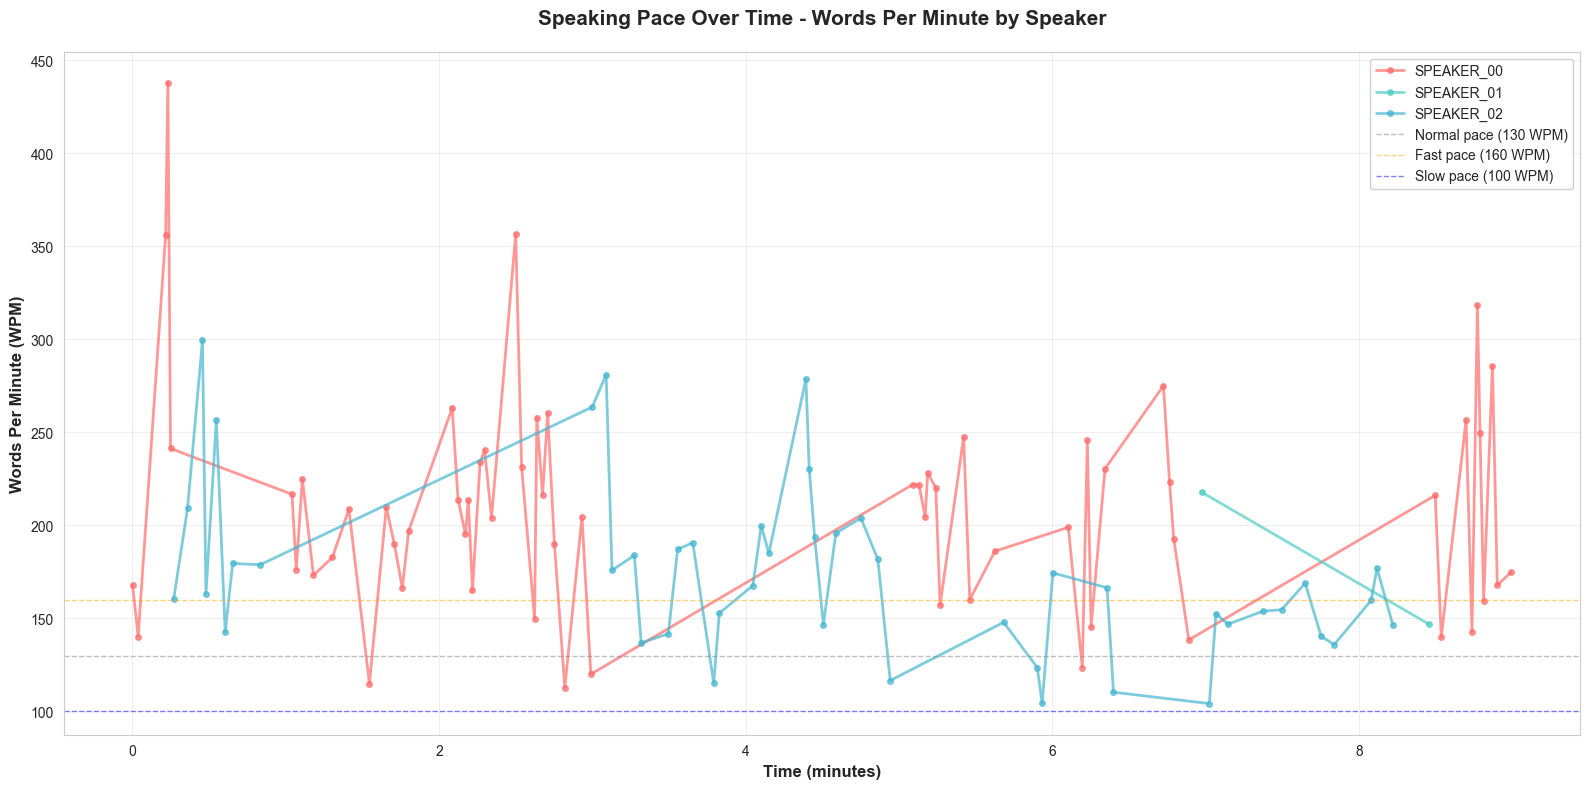

In [22]:
# ============================================================
# WPM LINE PLOT - SPEAKING PACE OVER TIME
# ============================================================

print("=" * 70)
print("CREATING WPM TIMELINE VISUALIZATION")
print("=" * 70)

# Get unique speakers
speakers = sorted(wpm_df['speaker'].unique())

# Define colors for each speaker
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#ffd93d', '#95e1d3']
speaker_colors = {speaker: colors[i % len(colors)] for i, speaker in enumerate(speakers)}

# ------------------------------------------------------------
# Create the line plot
# ------------------------------------------------------------

plt.figure(figsize=(16, 8))

# Plot WPM line for each speaker
for speaker in speakers:
    speaker_data = wpm_df[wpm_df['speaker'] == speaker]
    
    # Use segment start time as x-axis
    x = speaker_data['start'] / 60  # Convert to minutes
    y = speaker_data['wpm']
    
    # Plot line with markers
    plt.plot(x, y, 
             marker='o', 
             label=speaker, 
             color=speaker_colors[speaker],
             linewidth=2,
             markersize=4,
             alpha=0.7)

# ------------------------------------------------------------
# Add reference lines for speaking pace zones
# ------------------------------------------------------------

plt.axhline(y=130, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Normal pace (130 WPM)')
plt.axhline(y=160, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Fast pace (160 WPM)')
plt.axhline(y=100, color='blue', linestyle='--', linewidth=1, alpha=0.5, label='Slow pace (100 WPM)')

# ------------------------------------------------------------
# Styling
# ------------------------------------------------------------

plt.xlabel('Time (minutes)', fontsize=12, fontweight='bold')
plt.ylabel('Words Per Minute (WPM)', fontsize=12, fontweight='bold')
plt.title('Speaking Pace Over Time - Words Per Minute by Speaker', 
          fontsize=15, fontweight='bold', pad=20)

plt.legend(loc='upper right', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()

print("WPM timeline plot created!")
plt.show()


AVERAGE WPM COMPARISON

✓ Average WPM comparison chart created!


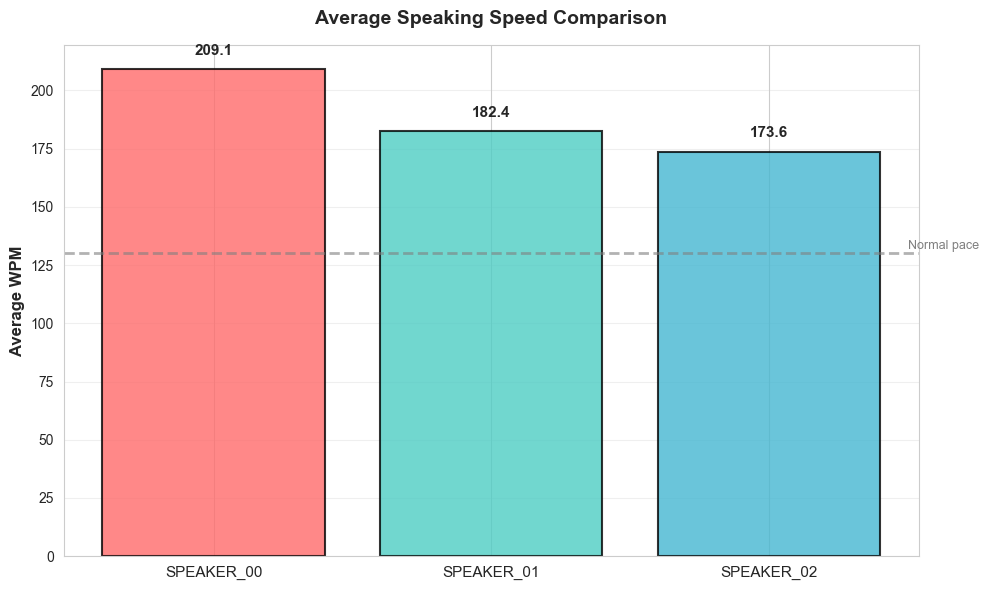


INTERPRETATION

SPEAKER_00: 209.1 WPM
  → Very fast - potentially overwhelming

SPEAKER_01: 182.4 WPM
  → Fast - confident or aggressive

SPEAKER_02: 173.6 WPM
  → Fast - confident or aggressive



In [ ]:
# ============================================================
# AVERAGE WPM BAR CHART
# ============================================================

print("=" * 70)
print("AVERAGE WPM COMPARISON")
print("=" * 70)

# Calculate average WPM per speaker
avg_wpm = wpm_df.groupby('speaker')['wpm'].mean().sort_values(ascending=False)

# Create bar chart
plt.figure(figsize=(10, 6))

bars = plt.bar(range(len(avg_wpm)), 
               avg_wpm.values, 
               color=[speaker_colors[speaker] for speaker in avg_wpm.index],
               alpha=0.8,
               edgecolor='black',
               linewidth=1.5)

# Add value labels on bars
for i, (speaker, wpm) in enumerate(avg_wpm.items()):
    plt.text(i, wpm + 5, f'{wpm:.1f}', 
             ha='center', va='bottom', 
             fontweight='bold', fontsize=11)

# Styling
plt.xticks(range(len(avg_wpm)), avg_wpm.index, fontsize=11)
plt.ylabel('Average WPM', fontsize=12, fontweight='bold')
plt.title('Average Speaking Speed Comparison', fontsize=14, fontweight='bold', pad=15)

# Add reference line
plt.axhline(y=130, color='gray', linestyle='--', linewidth=2, alpha=0.6)
plt.text(len(avg_wpm)-0.5, 132, 'Normal pace', fontsize=9, color='gray')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()

print("\nAverage WPM comparison chart created!")
plt.show()

# Print interpretation
print("\n" + "=" * 70)
print("INTERPRETATION")
print("=" * 70)

for speaker, wpm in avg_wpm.items():
    if wpm < 100:
        pace = "Very slow - deliberate or hesitant"
    elif wpm < 130:
        pace = "Slow - careful, measured"
    elif wpm < 160:
        pace = "Normal - conversational"
    elif wpm < 200:
        pace = "Fast - confident or aggressive"
    else:
        pace = "Very fast - potentially overwhelming"
    
    print(f"\n{speaker}: {wpm:.1f} WPM")
    print(f"  → {pace}")

print("\n" + "=" * 70)